In [1]:
%matplotlib notebook
import flux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [24]:
arbitrary_source = flux.catalog.obj_catalog[999]
arb_ra = arbitrary_source.ra_angle
arb_dec = arbitrary_source.dec_angle
J = flux.stokes.J_matrix(np.radians(arb_ra), np.radians(arb_dec))
J.shape
J

array([[[ 0.01991973+0.01664573j,  0.0076689 +0.01241009j],
        [-0.0099227 -0.01312429j, -0.00624945+0.00276545j]]])

In [22]:
arb_ra = flux.rot.get_lst(radians=True)
arb_dec = np.radians(flux.rot.hera_lat)
print(flux.rot.hera_lat)
J = flux.stokes.J_matrix(arb_ra, arb_dec, flux.rot.get_lst(True))

-30.72138888888889


In [19]:
J

array([[[0.-0.j, 0.+0.j],
        [0.-0.j, 0.+0.j]]])

In [28]:
Am = flux.stokes.A_matrix(np.radians(arb_ra), np.radians(arb_dec))
print(Am)
Am.shape

[[[ 0.01992763+0.01763027j  0.00722677+0.0127316j ]
  [-0.00960841-0.01363832j -0.00696693+0.00211149j]]]
[[[ 7.07936883e-04+0.00000000e+00j  3.68473929e-04-1.26300559e-04j
    3.68473929e-04+1.26300559e-04j  2.14319767e-04+0.00000000e+00j]
  [-4.31920115e-04+1.02380342e-04j -1.01608401e-04-1.64905815e-04j
   -2.43075337e-04-2.37694423e-05j -2.34658635e-05-1.03959397e-04j]
  [-4.31920115e-04-1.02380342e-04j -2.43075337e-04+2.37694423e-05j
   -1.01608401e-04+1.64905815e-04j -2.34658635e-05+1.03959397e-04j]
  [ 2.78325264e-04+0.00000000e+00j  3.81440764e-05+1.15305253e-04j
    3.81440764e-05-1.15305253e-04j  5.29965256e-05+0.00000000e+00j]]]
[[[ 2.71441148e-04-9.44130159e-05j  1.07195977e-05-4.41613934e-05j
    1.14678995e-04+1.46692510e-04j  4.57562023e-06+1.96793358e-04j]]

 [[-3.95150352e-04+1.18929220e-04j  8.53263872e-05+1.13257878e-04j
   -7.16295355e-05+8.97920140e-05j -3.67697623e-05+5.70157015e-05j]]

 [[-2.79845099e-04-1.97540120e-04j -8.29753915e-05+7.51138012e-05j
   -1.33938

(4, 1, 4)

In [8]:
flux.stokes.A_matrix??

In [9]:
Am[0][0][0]

0j

In [10]:
# Display available antennae
print(flux.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [11]:
# we sample three sources almost at random, and 2/3 are zero

print(arbitrary_source)
print(flux.vis.visibility(2, 11, arbitrary_source))

print(flux.vis.visibility(36, 37, flux.catalog.obj_catalog[981]))
print(flux.vis.visibility(88, 121, flux.catalog.obj_catalog[134]))
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

Name: GLEAM J185915-381842
Right ascension: 284.8155
Declination: -37.688250000000004
151 MHz flux: 1.2316479999999999

[[[-0.04292187-0.0155103j  -0.00967744-0.00822471j]
  [ 0.01483322+0.00586825j -0.02813131-0.02387082j]]]
[[[ 0.00208286+0.00000000e+00j  0.00054294-2.02919846e-04j
    0.00054294+2.02919846e-04j  0.0001613 +0.00000000e+00j]
  [-0.00072769+2.18087625e-05j  0.00157769-5.88255232e-04j
   -0.00019181-6.52092059e-05j  0.00046857+3.63316839e-07j]
  [-0.00072769-2.18087625e-05j -0.00019181+6.52092059e-05j
    0.00157769+5.88255232e-04j  0.00046857-3.63316839e-07j]
  [ 0.00025446+0.00000000e+00j -0.00055736+1.88999420e-04j
   -0.00055736-1.88999420e-04j  0.00136119+0.00000000e+00j]]]
[ 0.00205304+7.68888506e-04j -0.00048536-5.05923559e-04j
 -0.00049342-6.62671715e-05j  0.00079505+7.83532580e-04j]
[[[ 0.-0.j  0.+0.j]
  [-0.+0.j  0.+0.j]]]
[[[ 0.+0.j  0.-0.j  0.+0.j  0.+0.j]
  [-0.+0.j  0.-0.j  0.-0.j  0.+0.j]
  [-0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.-0.j  0.+

In [12]:
"""
This section kills the kernel! Do NOT run it!!
I am leaving it here as a to-do of sorts. I think, that my inability
to run it in this environment may be a bad sign.
(It does work fine in the shell, so far as I can tell.)

t = 0
arg = 134

obj = flux.catalog.obj_catalog[arg]
ra = np.radians(obj.ra_angle)
dec = np.radians(obj.dec_angle)
while t < 2 * np.pi:
    print(t)
    t += np.pi / 72
    
    print(flux.stokes.J_matrix(ra, dec, t))
    print("\n")

"""

'\nThis section kills the kernel! Do NOT run it!!\nI am leaving it here as a to-do of sorts. I think, that my inability\nto run it in this environment may be a bad sign.\n(It does work fine in the shell, so far as I can tell.)\n\nt = 0\narg = 134\n\nobj = flux.catalog.obj_catalog[arg]\nra = np.radians(obj.ra_angle)\ndec = np.radians(obj.dec_angle)\nwhile t < 2 * np.pi:\n    print(t)\n    t += np.pi / 72\n    \n    print(flux.stokes.J_matrix(ra, dec, t))\n    print("\n")\n\n'

In [13]:
vist = flux.vis.source_over_time(
    88, 121, arbitrary_source, 0, 2/3 * np.pi, np.pi / 72
)
vist

[[[-0.04292332-0.01550972j -0.00967799-0.00822495j]
  [ 0.01483385+0.00586815j -0.02813219-0.02387115j]]]
[[[ 0.00208296+0.00000000e+00j  0.00054298-2.02939340e-04j
    0.00054298+2.02939340e-04j  0.00016131+0.00000000e+00j]
  [-0.00072773+2.18117774e-05j  0.00157776-5.88306527e-04j
   -0.00019183-6.52157783e-05j  0.0004686 +3.61161757e-07j]
  [-0.00072773-2.18117774e-05j -0.00019183+6.52157783e-05j
    0.00157776+5.88306527e-04j  0.0004686 -3.61161757e-07j]
  [ 0.00025448+0.00000000e+00j -0.00055739+1.89017025e-04j
   -0.00055739-1.89017025e-04j  0.00136125+0.00000000e+00j]]]
[[[-0.04292371-0.01550956j -0.00967814-0.00822502j]
  [ 0.01483402+0.00586813j -0.02813243-0.02387124j]]]
[[[ 0.00208299+0.00000000e+00j  0.00054299-2.02944619e-04j
    0.00054299+2.02944619e-04j  0.00016132+0.00000000e+00j]
  [-0.00072774+2.18125939e-05j  0.00157778-5.88320416e-04j
   -0.00019183-6.52175580e-05j  0.00046861+3.60578128e-07j]
  [-0.00072774-2.18125939e-05j -0.00019183+6.52175580e-05j
    0.0015777

[[[-0.04292747-0.01550806j -0.00967956-0.00822566j]
  [ 0.01483567+0.00586787j -0.02813471-0.02387209j]]]
[[[ 0.00208327+0.00000000e+00j  0.00054308-2.02995291e-04j
    0.00054308+2.02995291e-04j  0.00016136+0.00000000e+00j]
  [-0.00072786+2.18204321e-05j  0.00157796-5.88453740e-04j
   -0.00019187-6.52346416e-05j  0.0004687 +3.54974090e-07j]
  [-0.00072786-2.18204321e-05j -0.00019187+6.52346416e-05j
    0.00157796+5.88453740e-04j  0.0004687 -3.54974090e-07j]
  [ 0.00025453+0.00000000e+00j -0.00055748+1.89067554e-04j
   -0.00055748-1.89067554e-04j  0.00136144+0.00000000e+00j]]]
[[[-0.04292773-0.01550796j -0.00967966-0.0082257j ]
  [ 0.01483578+0.00586785j -0.02813487-0.02387215j]]]
[[[ 0.00208329+0.00000000e+00j  0.00054309-2.02998740e-04j
    0.00054309+2.02998740e-04j  0.00016136+0.00000000e+00j]
  [-0.00072786+2.18209655e-05j  0.00157797-5.88462812e-04j
   -0.00019187-6.52358042e-05j  0.0004687 +3.54592632e-07j]
  [-0.00072786-2.18209655e-05j -0.00019187+6.52358042e-05j
    0.0015779

  [ 0.01483691+0.00586768j -0.02813644-0.02387274j]]]
[[[ 0.00208348+0.00000000e+00j  0.00054316-2.03033664e-04j
    0.00054316+2.03033664e-04j  0.00016138+0.00000000e+00j]
  [-0.00072794+2.18263688e-05j  0.0015781 -5.88554695e-04j
   -0.0001919 -6.52475785e-05j  0.00046876+3.50728445e-07j]
  [-0.00072794-2.18263688e-05j -0.0001919 +6.52475785e-05j
    0.0015781 +5.88554695e-04j  0.00046876-3.50728445e-07j]
  [ 0.00025456+0.00000000e+00j -0.00055754+1.89102205e-04j
   -0.00055754-1.89102205e-04j  0.00136157+0.00000000e+00j]]]
[[[-0.0429306 -0.01550682j -0.00968075-0.00822618j]
  [ 0.01483703+0.00586766j -0.02813661-0.0238728j ]]]
[[[ 0.0020835 +0.00000000e+00j  0.00054316-2.03037330e-04j
    0.00054316+2.03037330e-04j  0.00016139+0.00000000e+00j]
  [-0.00072795+2.18269361e-05j  0.00157811-5.88564341e-04j
   -0.0001919 -6.52488146e-05j  0.00046877+3.50322677e-07j]
  [-0.00072795-2.18269361e-05j -0.0001919 +6.52488146e-05j
    0.00157811+5.88564341e-04j  0.00046877-3.50322677e-07j]
  [ 0

array([[-2.10860241e-03-6.00355318e-04j,  5.24725216e-04+4.65042889e-04j,
         4.97188210e-04+2.61508721e-05j, -8.55863551e-04-7.16721065e-04j],
       [-2.19076196e-03-8.55806075e-05j,  6.19692699e-04+3.28024775e-04j,
         4.89315417e-04-9.19659051e-05j, -1.00089305e-03-4.94418276e-04j],
       [-2.00467558e-03+8.87807869e-04j,  7.00837229e-04+2.16537594e-05j,
         3.98842436e-04-2.98028868e-04j, -1.11637016e-03-3.20323506e-06j],
       [-1.01475795e-03+1.94353373e-03j,  5.61656149e-04-4.19763919e-04j,
         1.26252075e-04-4.81626571e-04j, -8.75172305e-04+6.93116446e-04j],
       [ 8.67895287e-04+2.01343771e-03j,  2.86079809e-05-7.00611735e-04j,
        -2.94062475e-04-4.01792853e-04j, -1.42868072e-05+1.11632103e-03j],
       [ 2.18835117e-03+1.35546032e-04j, -6.12088977e-04-3.42101102e-04j,
        -4.91314298e-04+8.07771601e-05j,  9.89413545e-04+5.17170041e-04j],
       [ 6.87677372e-04-2.08192964e-03j, -4.86534581e-04+5.04956161e-04j,
        -4.68409530e-05+4.957065

<IPython.core.display.Javascript object>


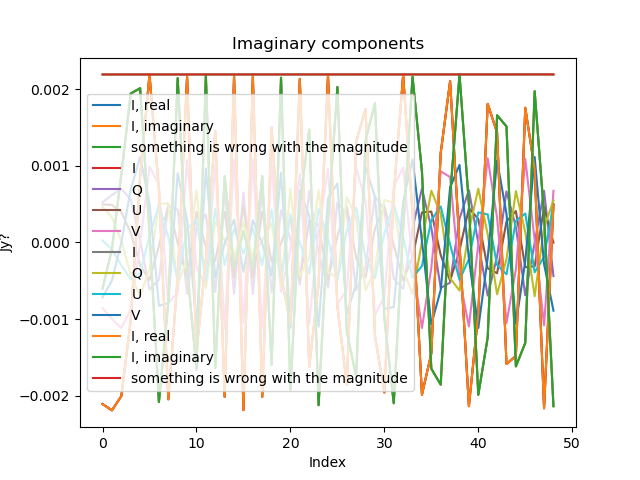

In [14]:
plt.plot(np.real(vist[:, 0]), label="I, real")
plt.plot(np.imag(vist[:, 0]), label="I, imaginary")
plt.plot(np.abs(vist[:, 0]), label="something is wrong with the magnitude")

plt.xlabel("Index")
plt.ylabel("Jy?")

plt.legend()

plt.show()

In [15]:
plt.plot(np.real(vist[:, 0]), label="I")
plt.plot(np.real(vist[:, 1]), label="Q")
plt.plot(np.real(vist[:, 2]), label="U")
plt.plot(np.real(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Real components")

plt.legend()

plt.show()

In [16]:
plt.plot(np.imag(vist[:, 0]), label="I")
plt.plot(np.imag(vist[:, 1]), label="Q")
plt.plot(np.imag(vist[:, 2]), label="U")
plt.plot(np.imag(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Imaginary components")

plt.legend()

plt.show()

In [17]:
vist = flux.vis.source_over_time(
    88, 121, arbitrary_source, 0, 2/3 * np.pi, np.pi / 72
)
plt.plot(np.real(vist[:, 0]), label="I, real")
plt.plot(np.imag(vist[:, 0]), label="I, imaginary")
plt.plot(np.abs(vist[:, 0]), label="something is wrong with the magnitude")

plt.xlabel("Index")
plt.ylabel("Jy?")

plt.legend()

plt.show()

[[[-0.0429359 -0.0155047j  -0.00968275-0.00822708j]
  [ 0.01483935+0.0058673j  -0.02813983-0.02387401j]]]
[[[ 0.00208389+0.00000000e+00j  0.0005433 -2.03108765e-04j
    0.0005433 +2.03108765e-04j  0.00016144+0.00000000e+00j]
  [-0.00072811+2.18379909e-05j  0.00157837-5.88752267e-04j
   -0.00019196-6.52728982e-05j  0.00046888+3.42414176e-07j]
  [-0.00072811-2.18379909e-05j -0.00019196+6.52728982e-05j
    0.00157837+5.88752267e-04j  0.00046888-3.42414176e-07j]
  [ 0.00025463+0.00000000e+00j -0.00055765+1.89170020e-04j
   -0.00055765-1.89170020e-04j  0.00136182+0.00000000e+00j]]]
[[[-0.0429361 -0.01550462j -0.00968283-0.00822711j]
  [ 0.01483944+0.00586728j -0.02813995-0.02387405j]]]
[[[ 0.0020839 +0.00000000e+00j  0.0005433 -2.03111450e-04j
    0.0005433 +2.03111450e-04j  0.00016144+0.00000000e+00j]
  [-0.00072812+2.18384064e-05j  0.00157838-5.88759330e-04j
   -0.00019196-6.52738034e-05j  0.00046889+3.42116809e-07j]
  [-0.00072812-2.18384064e-05j -0.00019196+6.52738034e-05j
    0.0015783

  [ 0.01484154+0.00586696j -0.02814286-0.02387514j]]]
[[[ 0.00208426+0.00000000e+00j  0.00054342-2.03176215e-04j
    0.00054342+2.03176215e-04j  0.00016149+0.00000000e+00j]
  [-0.00072826+2.18484322e-05j  0.00157861-5.88929696e-04j
   -0.00019201-6.52956387e-05j  0.000469  +3.34941443e-07j]
  [-0.00072826-2.18484322e-05j -0.00019201+6.52956387e-05j
    0.00157861+5.88929696e-04j  0.000469  -3.34941443e-07j]
  [ 0.00025469+0.00000000e+00j -0.00055776+1.89230923e-04j
   -0.00055776-1.89230923e-04j  0.00136204+0.00000000e+00j]]]
[[[-0.04294152-0.01550246j -0.00968488-0.00822803j]
  [ 0.01484181+0.00586692j -0.02814324-0.02387528j]]]
[[[ 0.0020843 +0.00000000e+00j  0.00054344-2.03184503e-04j
    0.00054344+2.03184503e-04j  0.0001615 +0.00000000e+00j]
  [-0.00072828+2.18497154e-05j  0.00157864-5.88951496e-04j
   -0.00019201-6.52984329e-05j  0.00046901+3.34022904e-07j]
  [-0.00072828-2.18497154e-05j -0.00019201+6.52984329e-05j
    0.00157864+5.88951496e-04j  0.00046901-3.34022904e-07j]
  [ 0